In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

In [3]:
dataset=pd.read_csv("ml-100k/u.data",sep="\t", names="user_id,item_id,rating,timestamp".split(","))

In [4]:
dataset.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [5]:
len(dataset.user_id.unique()), len(dataset.item_id.unique())

(943, 1682)

In [6]:
dataset.user_id = dataset.user_id.astype('category').cat.codes.values
dataset.item_id = dataset.item_id.astype('category').cat.codes.values

In [7]:
dataset.head()


,user_id,item_id,rating,timestamp
0,195,241,3,881250949
1,185,301,3,891717742
2,21,376,1,878887116
3,243,50,2,880606923
4,165,345,1,886397596


In [8]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(dataset, test_size=0.2)

In [9]:
# Matrix factorisation
import keras
import tensorflow as tf 
from IPython.display import SVG
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
n_users, n_movies = len(dataset.user_id.unique()), len(dataset.item_id.unique())
n_latent_factors = 3

Using TensorFlow backend.


In [10]:
movie_input=keras.layers.Input(shape=[1],name="Item")
movie_embedding=keras.layers.Embedding(n_movies,n_latent_factors,name='Movie-Embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

user_input = keras.layers.Input(shape=[1],name='User')
user_embedding=keras.layers.Embedding(n_users , n_latent_factors,name='User-Embedding')(user_input)
user_vec = keras.layers.Flatten(name='FlattenUsers')(user_embedding)

prod = keras.layers.merge.dot([movie_vec, user_vec],axes=-1,name='DotProduct')
model = keras.Model([user_input, movie_input], prod)
model.compile('adam', 'mean_squared_error')

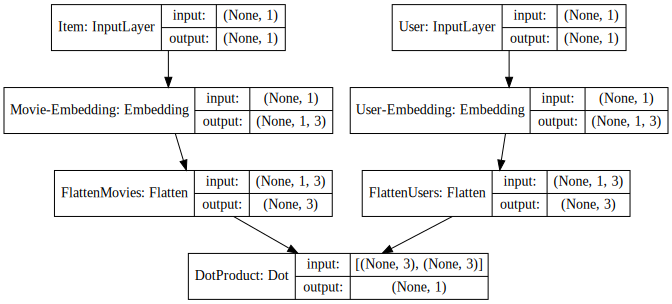

In [11]:
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

In [12]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 3)         5046        Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 3)         2829        User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

In [13]:
history=model.fit([train.user_id,train.item_id],train.rating,epochs=100,verbose=0)

Text(0, 0.5, 'Train Error')

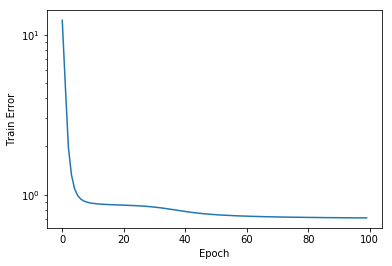

In [14]:
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")

In [15]:
y_hat = np.round(model.predict([test.user_id, test.item_id]),0)
y_true=test.rating

In [16]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, y_hat)

0.6974

In [17]:
movie_embedding_learnt = model.get_layer(name='Movie-Embedding').get_weights()[0]
pd.DataFrame(movie_embedding_learnt).describe()

,0,1,2
count,1682.000000,1682.000000,1682.000000
mean,-0.880215,0.998789,-0.887047
std,0.550130,0.471856,0.431068
min,-2.296970,-1.017873,-2.147054
25%,-1.324598,0.694807,-1.193305
50%,-0.887481,1.004846,-0.901716
75%,-0.481867,1.309018,-0.568403
max,1.127116,3.396826,0.559773


In [ ]:


###   Non-negative Matrix factorisation (NNMF)



In [20]:
from keras.constraints import non_neg
movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding = keras.layers.Embedding(n_movies , n_latent_factors, name='NonNegMovie-Embedding', embeddings_constraint=non_neg())(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users, n_latent_factors,name='NonNegUser-Embedding',embeddings_constraint=non_neg())(user_input))

prod = keras.layers.merge.dot([movie_vec, user_vec], axes=-1,name='DotProduct')
model = keras.Model([user_input, movie_input], prod)
model.compile('adam', 'mean_squared_error')

In [21]:
history_nonneg = model.fit([train.user_id, train.item_id], train.rating, epochs=10, verbose=0)

In [22]:
y_hat = np.round(model.predict([test.user_id, test.item_id]),0)
y_true=test.rating

In [23]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, y_hat)

0.72015

In [ ]:

#### Neural networks for recommendation



In [24]:
n_latent_factors_user = 5
n_latent_factors_movie = 8

movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding = keras.layers.Embedding(n_movies , n_latent_factors_movie, name='Movie-Embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)
movie_vec = keras.layers.Dropout(0.2)(movie_vec)


user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users , n_latent_factors_user,name='User-Embedding')(user_input))
user_vec = keras.layers.Dropout(0.2)(user_vec)


concat = keras.layers.merge.concatenate([movie_vec, user_vec],axis=-1,name='Concat')

concat_dropout = keras.layers.Dropout(0.2)(concat)

dense = keras.layers.Dense(200,name='FullyConnected')(concat)
dropout_1 = keras.layers.Dropout(0.2,name='Dropout')(dense)

dense_2 = keras.layers.Dense(100,name='FullyConnected-1')(concat)
dropout_2 = keras.layers.Dropout(0.2,name='Dropout')(dense_2)

dense_3 = keras.layers.Dense(50,name='FullyConnected-2')(dense_2)
dropout_3 = keras.layers.Dropout(0.2,name='Dropout')(dense_3)

dense_4 = keras.layers.Dense(20,name='FullyConnected-3', activation='relu')(dense_3)


result = keras.layers.Dense(1, activation='relu',name='Activation')(dense_4)
adam = Adam(lr=0.005)
model = keras.Model([user_input, movie_input], result)
model.compile(optimizer=adam,loss= 'mean_absolute_error')

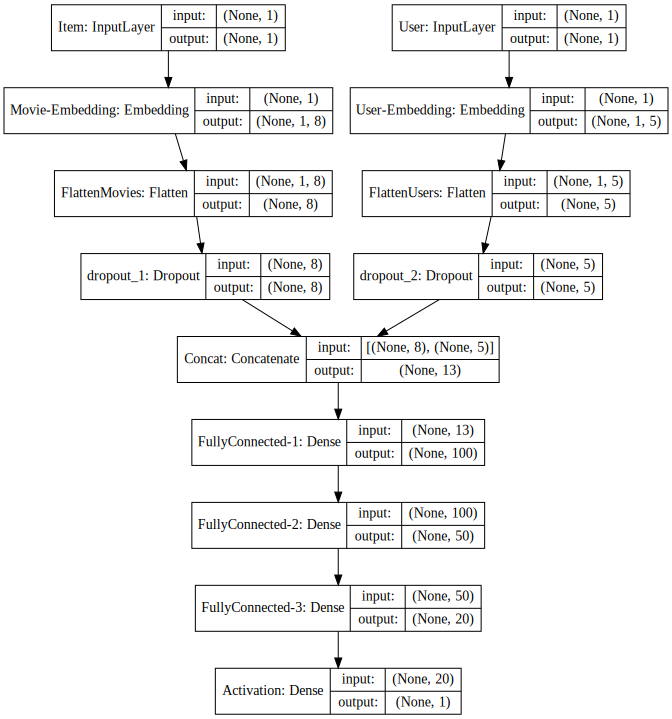

In [25]:
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

In [26]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 8)         13456       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 5)         4715        User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

In [27]:
history = model.fit([train.user_id, train.item_id], train.rating, epochs=200, verbose=0)

In [28]:
y_hat_2 = np.round(model.predict([test.user_id, test.item_id]),0)
print(mean_absolute_error(y_true, y_hat_2))

print(mean_absolute_error(y_true, model.predict([test.user_id, test.item_id])))

0.6991
0.7071426998615264
